# Group 14 - Project FP01
## Time series anomaly detection - XGBoost

This project aims at investigating the current state-of-the-arts TAD scenario using XGBoost.

In [ ]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install xgboost
# !pip install -U kaleido

In [2]:
import os
import time
import tsfel
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

from dataset import get_df_action, get_features_ts, get_train_test_data
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import Confidence, anomaly_detection_metric, compute_metrics

# Set style for matplotlib
plt.style.use("Solarize_Light2")

2024-07-15 01:21:24.870248: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 01:21:24.896171: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-15 01:21:24.896200: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-15 01:21:24.896216: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-15 01:21:24.901642: I tensorflow/core/platform/cpu_feature_g

In [3]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL = '../../dataset/normal'
ROOTDIR_DATASET_ANOMALY = '../../dataset/collisions'

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being monitored by several sensors. The sensed signals are collected, with different sampling frequencies (1, 10, 100, 200 Hz).

### Data Loading

In [4]:
freq = '0.1'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



### Features Extraction

In [5]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 98.15674161911011 seconds ---


In [6]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)


## XGBoost for Anomaly Detection

In [7]:
# Initialize and train XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

print("XGBoost training completed.")

XGBoost training completed.


### Anomaly Detection

Anomaly prediction completed.


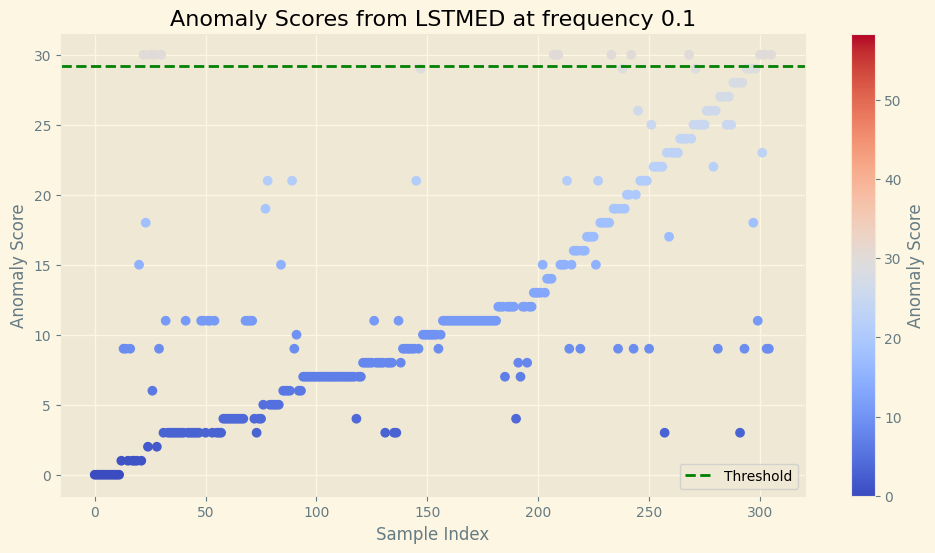

Number of anomalies detected: 13


(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  9,  9,  1,  9,
         1,  1,  1, 15,  1, 30, 18,  2, 30,  6, 30,  2,  9, 30,  3, 11,  3,
         3,  3,  3,  3,  3,  3,  3, 11,  3,  3,  3,  3,  3,  3, 11, 11,  3,
        11, 11,  3, 11,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        11, 11, 11, 11,  4,  3,  4,  4,  5, 19, 21,  5,  5,  5,  5,  5, 15,
         6,  6,  6,  6, 21,  9, 10,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  4,
         7,  7,  8,  8,  8,  8,  8, 11,  8,  8,  8,  8,  3,  8,  8,  8,  3,
         3, 11,  8,  9,  9,  9,  9,  9,  9, 21,  9, 29, 10, 10, 10, 10, 10,
        10, 10,  9, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12,  7, 12,
        12, 12, 12,  4,  8,  7, 12, 12,  8, 12, 12, 13, 13, 13, 13, 15, 13,
        14, 14, 14, 30, 30, 30, 15, 15, 15, 21,  9, 15, 16, 16, 16,  9, 16,
        16, 

In [8]:
# Use predict_proba to get probability scores
anomaly_scores = 1 - xgb_model.predict_proba(X_test)[:, 0]  # Use the probability of not being in the majority class
plot_anomalies(xgb_model, X_test, y_test, freq)

In [9]:
anomaly_scores, y_test_binary = compute_metrics(xgb_model, X_test, y_test)

Anomaly scores statistics:
Mean: 12.352941176470589
Std: 8.41914297738576
Min: 0
Max: 30
ROC AUC Score: 0.9111
Detected anomaly class: 27
Threshold: 29.1912
F1 Score: 0.0000
Accuracy: 0.9379
Precision: 0.0000
Recall: 0.0000
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       300
           1       0.00      0.00      0.00         6

    accuracy                           0.94       306
   macro avg       0.49      0.48      0.48       306
weighted avg       0.96      0.94      0.95       306



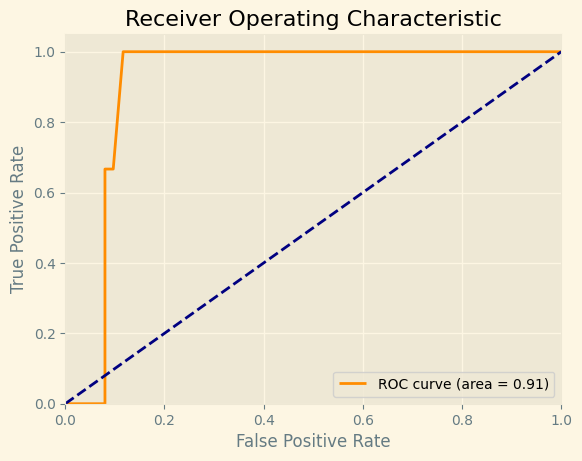

In [10]:
plot_roc_curve(y_test_binary, anomaly_scores)

## Map anomalies to original time series

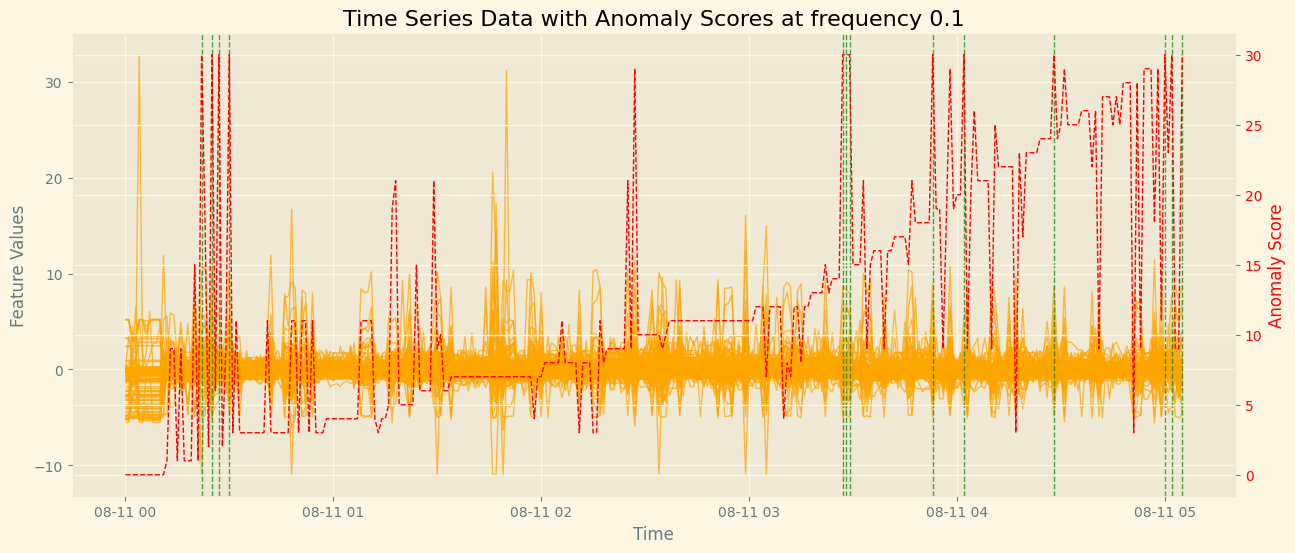

Top 13 Anomalies:
              timestamp  anomaly_score  \
22  2022-08-11 00:22:00             30   
25  2022-08-11 00:25:00             30   
27  2022-08-11 00:27:00             30   
30  2022-08-11 00:30:00             30   
207 2022-08-11 03:27:00             30   
208 2022-08-11 03:28:00             30   
209 2022-08-11 03:29:00             30   
233 2022-08-11 03:53:00             30   
242 2022-08-11 04:02:00             30   
268 2022-08-11 04:28:00             30   
300 2022-08-11 05:00:00             30   
302 2022-08-11 05:02:00             30   
305 2022-08-11 05:05:00             30   

     machine_nameKuka Robot_apparent_power-_Average power  \
22                                           -0.820232      
25                                           -0.907927      
27                                           -0.095962      
30                                           -1.832763      
207                                          -1.303018      
208                        

In [11]:
plot_anomalies_over_time(X_test, anomaly_scores, sum(anomaly_scores > np.mean(anomaly_scores) + 2 * np.std(anomaly_scores)), freq)